# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Flatten
import warnings

# Suppressing warnings for cleaner output
warnings.filterwarnings('ignore')


In [2]:
# Reading the CSV file into a Pandas DataFrame
df = pd.read_csv("movie.csv")


In [3]:
df

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [4]:
df.head(10)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


In [5]:
# Displaying concise information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [6]:
# Calculating the number of unique values in each column of the DataFrame
df.nunique()

text     39723
label        2
dtype: int64

In [7]:
# Calculating the number of duplicated rows in the DataFrame
df.duplicated().sum()

277

# Data Analysis

In [8]:
# Importing the WordCloud class from the wordcloud module
from wordcloud import WordCloud

In [9]:
# Calculating the word count for each text entry in the DataFrame
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

In [10]:
def plot_target_hist(df, col):
    """
    Plotting a histogram of the target variable in the DataFrame.

    Parameters:
    - df: DataFrame containing the data
    - col: Column name of the target variable
    
    Returns:
    - None
    """
    # Counting the occurrences of each outcome
    outcome_counts = df[col].value_counts()
    total = outcome_counts.sum()
    
    # Calculating the percentage of each outcome
    outcome_percentages = outcome_counts / total * 100

    # Plotting the histogram
    out_hist = outcome_counts.plot(kind='bar', figsize=(3.5, 3.5))
    plt.xticks(rotation=0, fontsize=9)
    plt.yticks(range(0, max(outcome_counts) + 1, 5000), fontsize=9)
    plt.xlabel(None)

    # Adding percentage labels to the bars
    for i, percentage in enumerate(outcome_percentages):
        plt.text(i, outcome_counts[i], f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

    plt.show()

In [11]:
def plot_col_hist(df, col):
    """
    Plotting histograms of a specified column based on different labels.

    Parameters:
    - df: DataFrame containing the data
    - col: Column name for which histograms will be plotted
    
    Returns:
    - None
    """
    # Setting the figure size for the plot
    plt.figure(figsize=(14, 3.5))
    
    # Plotting histograms for label 1 and label 0
    plt.hist(df[df['label'] == 1][col], bins=50, alpha=0.6, color='#1F77B4', label='1')
    plt.hist(df[df['label'] == 0][col], bins=50, alpha=0.6, color='#D62728', label='0')
    
    # Setting tick parameters
    plt.tick_params(labelsize=9)
    plt.xticks(range(0, max(df[col])+1, 250))
    
    # Adding legend
    plt.legend(fontsize=8)
    
    # Displaying the plot
    plt.show()

In [12]:
def plot_word_cloud(df, lbl):
    """
    Plotting a word cloud for text data based on a specified label.

    Parameters:
    - df: DataFrame containing the data
    - lbl: Label value for which the word cloud will be generated
    
    Returns:
    - None
    """
    # Setting the figure size for the word cloud
    figsize=(14.7, 7.35)
    
    # Concatenating text data based on the specified label
    text = ' '.join(df[df['label'] == lbl]['text'])
    
    # Generating the word cloud
    wordcloud = WordCloud(width=int(figsize[0]*100), height=int(figsize[1]*100), background_color='black').generate(text)

    # Plotting the word cloud
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


# Univariate analysis

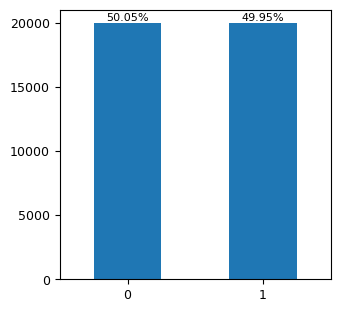

In [13]:
# Calling the function to plot a histogram
plot_target_hist(df, 'label')


# Multivariate analysis

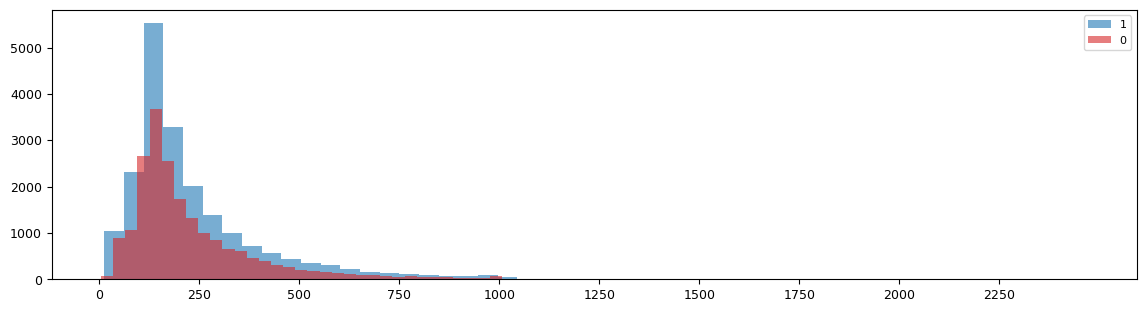

In [14]:
plot_col_hist(df, 'word_count')

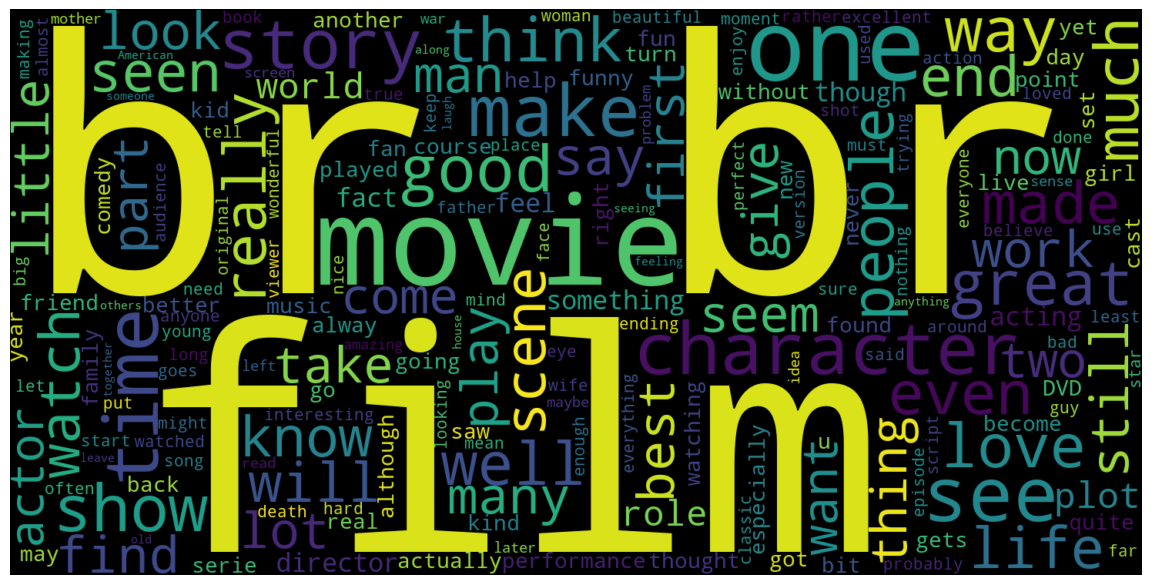

In [15]:
# Calling the function to plot a word cloud based on label 1 
plot_word_cloud(df, 1)


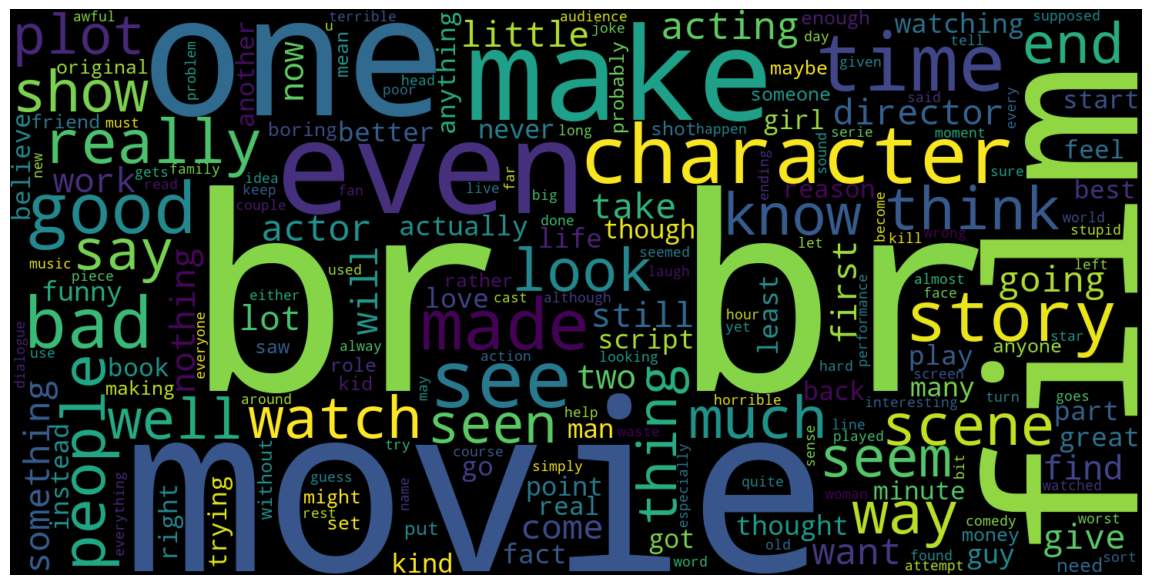

In [16]:
# Calling the function to plot a word cloud based on label 0 
plot_word_cloud(df, 0)

# Data preprocessing

In [17]:
import subprocess
import re
import string 
import nltk
import os
# Set the NLTK data path to a local directory
nltk.data.path.append('./nltk_data')

In [18]:
def clean_text(text):
    """
    Clean the input text by converting to lowercase, removing URLs, HTML tags, punctuation,
    newlines, alphanumeric characters, and digits.
    
    Parameters:
    - text: Input text to be cleaned
    
    Returns:
    - Cleaned text
    """
    # Convert text to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove newlines
    text = re.sub('\n', '', text)
    
    # Remove alphanumeric characters
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [19]:
def preprocess_data(text):
    """
    Preprocess the input text by removing stopwords, lemmatizing words, and filtering out short words.

    Parameters:
    - text: Input text to be preprocessed
    
    Returns:
    - Preprocessed text
    """
    # Create a set of English stopwords
    stopwords_set = set(stopwords.words('english'))
    
    # Remove stopwords from the text
    text = ' '.join(word for word in text.split() if word not in stopwords_set)
    
    # Lemmatize words using WordNetLemmatizer
    lemma = WordNetLemmatizer()
    text = ' '.join(lemma.lemmatize(word) for word in text.split())
    
    # Filter out short words (length <= 2)
    text = ' '.join(word for word in text.split() if len(word) > 2)
    
    return text


In [20]:
# Dropping duplicate rows from the DataFrame inplace
df.drop_duplicates(inplace=True)

# Importing stopwords and WordNetLemmatizer from NLTK
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [21]:
# Applying the clean_text function to each text entry in the 'text' column and storing the result in a new column 'clean_text'
df['clean_text'] = df['text'].apply(clean_text)

# Applying the preprocess_data function to each cleaned text entry in the 'clean_text' column and storing the result in a new column 'final_text'
df['final_text'] = df['clean_text'].apply(preprocess_data)


In [22]:
# Reordering the columns in the DataFrame to include only 'text', 'clean_text', 'final_text', and 'label'
df = df[['text', 'clean_text', 'final_text', 'label']]

# Setting the display option to show the full width of the columns in the DataFrame
pd.set_option('display.max_colwidth', None)

# Creating a new DataFrame containing the row with index 1 and displaying it
pd.DataFrame(df.iloc[1]).transpose()


,text,clean_text,final_text,label
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, but the animation in particular is a sad sight. The storyline is also pretty weak, as its more like three episodes of Schooby-Doo than the single adventurous story we got the last time. But dont misunderstand, it's not very good Schooby-Doo episodes. I didnt laugh a single time, although I might have sniggered once or twice.<br /><br />To the audience who haven't seen the first movie, or don't especially care for a similar sequel, here is a fast review of this movie as a stand-alone product: If you liked schooby-doo, you might like this movie. If you didn't, you could still enjoy this movie if you have nothing else to do. And I suspect it might be a good kids movie, but I wouldn't know. It might have been better if Milo's Return had been a three-episode series on a cartoon channel, or on breakfast TV.",when i put this movie in my dvd player and sat down with a coke and some chips i had some expectations i was hoping that this movie would contain some of the strongpoints of the first movie awsome animation good flowing story excellent voice cast funny comedy and a kickass soundtrack but to my disappointment not any of this is to be found in atlantis milos return had i read some reviews first i might not have been so let down the following paragraph will be directed to those who have seen the first movie and who enjoyed it primarily for the points mentionedwhen the first scene appears your in for a shock if you just picked atlantis milos return from the displaycase at your local videoshop or whatever and had the expectations i had the music feels as a bad imitation of the first movie and the voice cast has been replaced by a not so fitting one with the exception of a few characters like the voice of sweet the actual drawings isnt that bad but the animation in particular is a sad sight the storyline is also pretty weak as its more like three episodes of schoobydoo than the single adventurous story we got the last time but dont misunderstand its not very good schoobydoo episodes i didnt laugh a single time although i might have sniggered once or twiceto the audience who havent seen the first movie or dont especially care for a similar sequel here is a fast review of this movie as a standalone product if you liked schoobydoo you might like this movie if you didnt you could still enjoy this movie if you have nothing else to do and i suspect it might be a good kids movie but i wouldnt know it might have been better if milos return had been a threeepisode series on a cartoon channel or on breakfast tv,put movie dvd player sat coke chip expectation hoping movie would contain strongpoints first movie awsome animation good flowing story excellent voice cast funny comedy kickass soundtrack disappointment found atlantis milo return read review first might let following paragraph directed seen first movie enjoyed primarily point mentionedwhen first scene appears shock picked atlantis milo return displaycase local videoshop w

#  Machine Learning Model Training

In [23]:
# Importing TfidfVectorizer for feature extraction, train_test_split for data splitting, ComplementNB for Naive Bayes classification,
# cross_val_score and KFold for cross-validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score, KFold

In [24]:
def get_models():
    """
    Create a list of models for classification.

    Returns:
    - List of tuples, each containing a model name and its corresponding classifier instance
    """
    # Initialize an empty list to store the models
    models = []
    
    # Add Complement Naive Bayes classifier to the list of models
    models.append(('NB', ComplementNB()))
    
    return models

In [25]:
def train_models(X_train, y_train, models):
    """
    Train the specified models using cross-validation and print the mean accuracy for each model.

    Parameters:
    - X_train: Features of the training data
    - y_train: Target labels of the training data
    - models: List of tuples containing model names and corresponding classifier instances
    
    Returns:
    - Tuple containing lists of model names and their corresponding cross-validation results
    """
    # Number of splits for cross-validation
    n_splits = 10
    
    # Scoring metric for evaluation
    scoring = 'accuracy'

    # Lists to store results and model names
    results = []
    names = []

    # Loop through each model
    for name, model in models:
        # Perform cross-validation and calculate mean accuracy
        cv_results = cross_val_score(model, X_train, y_train, cv=KFold(n_splits=n_splits), scoring=scoring)
        results.append(cv_results)
        names.append(name)
        mean_accuracy = "{:.4f}".format(cv_results.mean())
        
        # Print mean accuracy for each model
        msg = f"{name}: {mean_accuracy}"
        print(msg)

    return names, results


In [26]:
# Creating a TfidfVectorizer instance for feature extraction
tfidf = TfidfVectorizer(lowercase=False)

# Transforming the text data into TF-IDF features
X = tfidf.fit_transform(df.text)

# Extracting target labels
y = df.label.values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Displaying the TF-IDF features
X

<39723x118017 sparse matrix of type '<class 'numpy.float64'>'
	with 5627686 stored elements in Compressed Sparse Row format>

In [27]:
# Get a list of models for classification
models = get_models()

# Train the models using cross-validation and obtain model names and cross-validation results
names, results = train_models(X_train, y_train, models)

NB: 0.8645


# Hyperparameters Tunning of Naive_bayes

In [28]:
# Importing Optuna for hyperparameter optimization, GridSearchCV for grid search, and metrics from scikit-learn
import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *


In [29]:
class OptunaSearch(object):
    def __init__(self, X_train, y_train, model, hyperparameters):
        """
        Initialize the OptunaSearch object with training data, model, and hyperparameters.

        Parameters:
        - X_train: Features of the training data
        - y_train: Target labels of the training data
        - model: Classifier model to be optimized
        - hyperparameters: Dictionary containing hyperparameter names and their possible values
        """
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
    
    def objective(self, trial):
        """
        Objective function for Optuna to optimize.

        Parameters:
        - trial: Optuna's Trial object to define hyperparameter search spaces
        
        Returns:
        - Mean cross-validation score of the model with the current hyperparameters
        """
        # Generate a set of hyperparameters to try
        params = {param_name: trial.suggest_categorical(param_name, param_values) 
                  for param_name, param_values in self.hyperparameters.items()}
        
        # Set the model with the current set of hyperparameters
        self.model.set_params(**params)        
        # Perform cross-validation and return the mean score
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=10, n_jobs=-1)        
        return cv_scores.mean()
    
    def BestModelPredict(self, X_test, n_trials=100):
        """
        Optimize hyperparameters using Optuna and return the best model with predictions.

        Parameters:
        - X_test: Features of the testing data
        - n_trials: Number of trials for hyperparameter optimization (default is 100)
        
        Returns:
        - Tuple containing the best model and its predictions on the testing data
        """
        # Suppress Optuna's verbosity
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        # Create an Optuna study and optimize hyperparameters
        study = optuna.create_study(direction="maximize")
        study.optimize(self.objective, n_trials=n_trials)
        
        # Get the best hyperparameters and update the model
        best_params = study.best_params
        self.model.set_params(**best_params)
        # Fit the best model on the training data
        self.model.fit(self.X_train, self.y_train)        
        # Make predictions on the testing data using the best model
        pred = self.model.predict(X_test)
        # Get the best score obtained during optimization
        best_score = study.best_value
        print("Best score: {} using parameters: {}".format(best_score, best_params))
        # Return the best model and its predictions
        return self.model, pred


In [30]:
class GridSearch(object):
    def __init__(self, X_train, y_train, model, hyperparameters):
        """
        Initialize the GridSearch object with training data, model, and hyperparameters.

        Parameters:
        - X_train: Features of the training data
        - y_train: Target labels of the training data
        - model: Classifier model to be optimized
        - hyperparameters: Dictionary containing hyperparameter names and their possible values
        """
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
    
    def GridSearch(self):
        """
        Perform grid search to find the best model with optimal hyperparameters.

        Returns:
        - Best model obtained from grid search
        """
        # Set the number of folds for cross-validation
        cv = 10 
        # Initialize GridSearchCV with the model, hyperparameters, and cross-validation settings
        clf = GridSearchCV(self.model, self.hyperparameters, cv=cv, verbose=0, n_jobs=-1,)
        # Fit the grid search object to the training data
        best_model = clf.fit(self.X_train, self.y_train)
        # Get the best score and best parameters from grid search
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))
        # Return the best model and its best parameters
        return best_model, best_model.best_params_
    
    def BestModelPridict(self, X_test):
        """
        Make predictions using the best model obtained from grid search.

        Parameters:
        - X_test: Features of the testing data
        
        Returns:
        - Best model obtained from grid search and its predictions on the testing data
        """
        # Obtain the best model and best parameters from grid search
        best_model,_ = self.GridSearch()
        # Make predictions on the testing data using the best model
        pred = best_model.predict(X_test)
        # Return the best model and its predictions
        return best_model, pred


In [31]:
# Create a Complement Naive Bayes model
nb_model = ComplementNB()

# Define hyperparameters for grid search
hyperparameters = {'alpha': [0.1, 0.5, 1.0],
                   'force_alpha': [True, False],
                   'fit_prior': [True, False], 
                   'class_prior': [None, [0.2, 0.8], [0.5, 0.5]], 
                   'norm': [True, False]}


In [32]:
# Create an OptunaSearch object for hyperparameter optimization with Complement Naive Bayes model
optuna_search_obj_nb = OptunaSearch(X_train, y_train, nb_model, hyperparameters)

# Obtain the best model and predictions using OptunaSearch
best_model_opt, optuna_search_predictions_nb = optuna_search_obj_nb.BestModelPredict(X_test)

# Calculate accuracy of the best model obtained from OptunaSearch
accuracy_optuna_search_nb = accuracy_score(y_test, optuna_search_predictions_nb)

# Print the accuracy obtained from OptunaSearch
print("Optuna Search Accuracy:", accuracy_optuna_search_nb)


Best score: 0.8643396240243902 using parameters: {'alpha': 1.0, 'force_alpha': False, 'fit_prior': False, 'class_prior': [0.2, 0.8], 'norm': False}
Optuna Search Accuracy: 0.8675896790434235


In [33]:
# Create a GridSearch object for hyperparameter tuning with Complement Naive Bayes model
grid_search_obj_nb = GridSearch(X_train, y_train, nb_model, hyperparameters)

# Obtain the best model and predictions using GridSearch
best_model_gs, grid_search_predictions_nb = grid_search_obj_nb.BestModelPridict(X_test)

# Calculate accuracy of the best model obtained from GridSearch
accuracy_grid_search_nb = accuracy_score(y_test, grid_search_predictions_nb)

# Print the accuracy obtained from GridSearch
print("Grid Search Accuracy:", accuracy_grid_search_nb)


Best: 0.864340 using {'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True, 'norm': False}
Grid Search Accuracy: 0.8675896790434235


In [34]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot the confusion matrix.

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    
    Returns:
    - None
    """
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix with annotations
    plt.figure(figsize=(3.5, 3.5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 9, "weight": "light"})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    # Add count and percentage annotations to the confusion matrix
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in conf_matrix.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plot the confusion matrix with count and percentage annotations
    sns.heatmap(conf_matrix, annot=labels, cmap='Blues', fmt='', cbar=False, annot_kws={"size": 9, "weight": "light"})
    plt.show()


In [35]:
def plot_roc_curve(classifier, X_test, y_test, classifier_name='Classifier'):
    """
    Plot the ROC curve for a classifier and calculate its AUC score.

    Parameters:
    - classifier: Classifier model
    - X_test: Features of the testing data
    - y_test: True labels of the testing data
    - classifier_name: Name of the classifier (default is 'Classifier')
    
    Returns:
    - None
    """
    # Calculate the predicted probabilities for positive class
    classifier_probs = classifier.predict_proba(X_test)[:, 1]
    
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, classifier_probs)

    # Plot the ROC curve
    plt.figure(figsize=(3.5, 3.5))
    plt.plot(fpr, tpr, label=classifier_name)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Calculate the AUC score
    roc_auc = roc_auc_score(y_test, classifier_probs)
    print(f'{classifier_name} AUC Score: {roc_auc:.4f}')


In [36]:
def plot_roc_curve(classifier, X_test, y_test, classifier_name='Classifier'):
    """
    Plot the ROC curve for a classifier and calculate its AUC score.

    Parameters:
    - classifier: Classifier model
    - X_test: Features of the testing data
    - y_test: True labels of the testing data
    - classifier_name: Name of the classifier (default is 'Classifier')
    
    Returns:
    - None
    """
    # Calculate the predicted probabilities for positive class
    classifier_probs = classifier.predict_proba(X_test)[:, 1]
    
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, classifier_probs)

    # Plot the ROC curve
    plt.figure(figsize=(3.5, 3.5))
    plt.plot(fpr, tpr, label=classifier_name)  # Use the classifier_name parameter here
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Calculate the AUC score
    roc_auc = roc_auc_score(y_test, classifier_probs)
    print(f'{classifier_name} AUC Score: {roc_auc:.4f}')


In [37]:
# Generate and print the classification report
classification_report_result = classification_report(y_test, grid_search_predictions_nb)
print("Classification Report:\n", classification_report_result)


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      3991
           1       0.88      0.85      0.86      3954

    accuracy                           0.87      7945
   macro avg       0.87      0.87      0.87      7945
weighted avg       0.87      0.87      0.87      7945



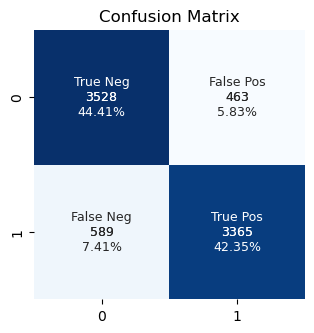

In [38]:
# Plot the confusion matrix using true labels (y_test) and predicted labels (grid_search_predictions_nb)
plot_confusion_matrix(y_test, grid_search_predictions_nb)

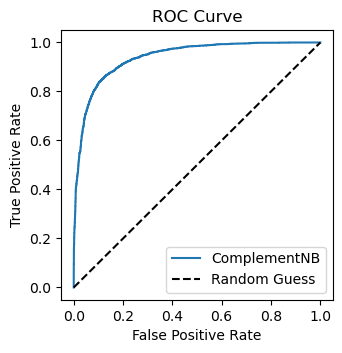

ComplementNB AUC Score: 0.9391


In [39]:
plot_roc_curve(best_model_opt, X_test, y_test, classifier_name='ComplementNB')

# Logistic Regression

In [40]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_pred = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_pred))
print("Logistic Regression F1 Score:", f1_score(y_test, log_pred, average='weighted'))

Logistic Regression Accuracy: 0.8952800503461297
Logistic Regression F1 Score: 0.8952716554959197


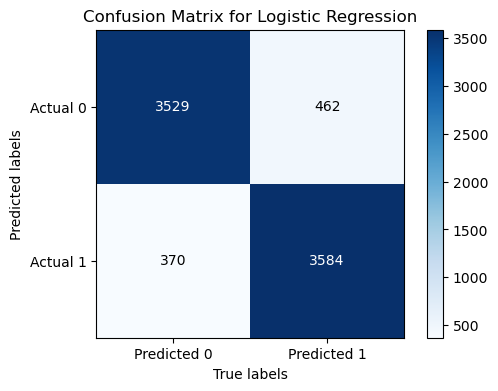

In [48]:
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(y_test, log_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.colorbar()
plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], ['Actual 0', 'Actual 1'])
plt.xlabel('True labels')
plt.ylabel('Predicted labels')

# Add numerical values to the cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()


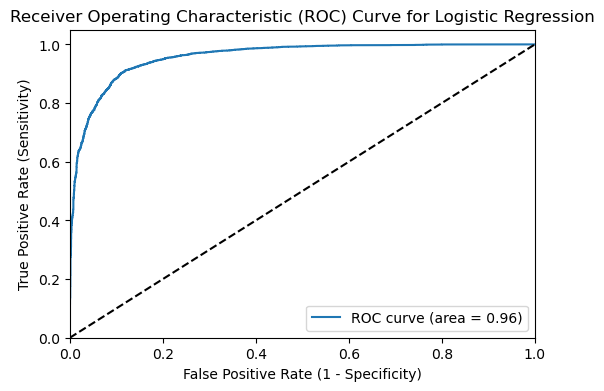

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Generate ROC curve
log_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, log_prob)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, log_prob))
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()


# LSTM Model

In [41]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['text'])
X_dl = tokenizer.texts_to_sequences(df['text'])
X_dl = pad_sequences(X_dl, maxlen=200)
y_dl = np.array(df['label'])

## Splitting the data for deep learning models
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42)

## LSTM Model
model_lstm = Sequential([
    Embedding(10000, 128, input_length=200),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train_dl, y_train_dl, epochs=5, validation_data=(X_test_dl, y_test_dl))



Epoch 1/5


994/994 [==============================] - 226s 220ms/step - loss: 0.3797 - accuracy: 0.8297 - val_loss: 0.3033 - val_accuracy: 0.8696
Epoch 2/5
994/994 [==============================] - 222s 223ms/step - loss: 0.2279 - accuracy: 0.9121 - val_loss: 0.2876 - val_accuracy: 0.8826
Epoch 3/5
994/994 [==============================] - 221s 223ms/step - loss: 0.1668 - accuracy: 0.9368 - val_loss: 0.3331 - val_accuracy: 0.8680
Epoch 4/5
994/994 [==============================] - 230s 232ms/step - loss: 0.1203 - accuracy: 0.9581 - val_loss: 0.3592 - val_accuracy: 0.8743
Epoch 5/5
994/994 [==============================] - 231s 233ms/step - loss: 0.0950 - accuracy: 0.9670 - val_loss: 0.4055 - val_accuracy: 0.8673


249/249 [==============================] - 17s 67ms/step
Confusion Matrix:
[[3426  565]
 [ 489 3465]]


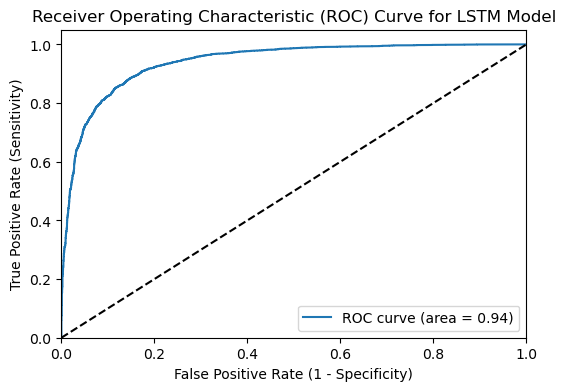

In [53]:
# Predict probabilities
y_pred_prob_dl = model_lstm.predict(X_test_dl)

# Convert probabilities to classes using a threshold of 0.5
y_pred_dl = np.where(y_pred_prob_dl > 0.5, 1, 0)

# Flatten predictions and true labels
y_pred_dl_flat = y_pred_dl.flatten()
y_test_dl_flat = y_test_dl.flatten()

# Confusion Matrix
cm_dl = confusion_matrix(y_test_dl_flat, y_pred_dl_flat)
print("Confusion Matrix:")
print(cm_dl)

# ROC curve
fpr_dl, tpr_dl, thresholds_dl = roc_curve(y_test_dl_flat, y_pred_prob_dl)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_dl, tpr_dl, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test_dl_flat, y_pred_prob_dl))
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve for LSTM Model')
plt.legend(loc="lower right")
plt.show()


# Feedforward Neural Network

In [42]:
# Feedforward Neural Network

model_ffnn = Sequential([
    Embedding(10000, 128, input_length=200),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_ffnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_ffnn = model_ffnn.fit(X_train_dl, y_train_dl, epochs=5, validation_data=(X_test_dl, y_test_dl))

Epoch 1/5
994/994 [==============================] - 28s 28ms/step - loss: 0.3732 - accuracy: 0.8232 - val_loss: 0.3015 - val_accuracy: 0.8715
Epoch 2/5
994/994 [==============================] - 28s 28ms/step - loss: 0.0896 - accuracy: 0.9684 - val_loss: 0.4298 - val_accuracy: 0.8617
Epoch 3/5
994/994 [==============================] - 28s 29ms/step - loss: 0.0159 - accuracy: 0.9947 - val_loss: 0.5756 - val_accuracy: 0.8688
Epoch 4/5
994/994 [==============================] - 26s 27ms/step - loss: 0.0087 - accuracy: 0.9970 - val_loss: 0.6788 - val_accuracy: 0.8553
Epoch 5/5
994/994 [==============================] - 26s 26ms/step - loss: 0.0121 - accuracy: 0.9955 - val_loss: 0.7683 - val_accuracy: 0.8595


In [43]:
# Predict probabilities
y_pred_prob_ffnn = model_ffnn.predict(X_test_dl)

# Convert probabilities to binary predictions
y_pred_ffnn = (y_pred_prob_ffnn > 0.5).astype(int)

# Confusion Matrix
cm_ffnn = confusion_matrix(y_test_dl, y_pred_ffnn)
print("Confusion Matrix:")
print(cm_ffnn)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_dl, y_pred_prob_ffnn)
roc_auc = auc(fpr, tpr)

249/249 [==============================] - 1s 4ms/step
Confusion Matrix:
[[3471  520]
 [ 596 3358]]


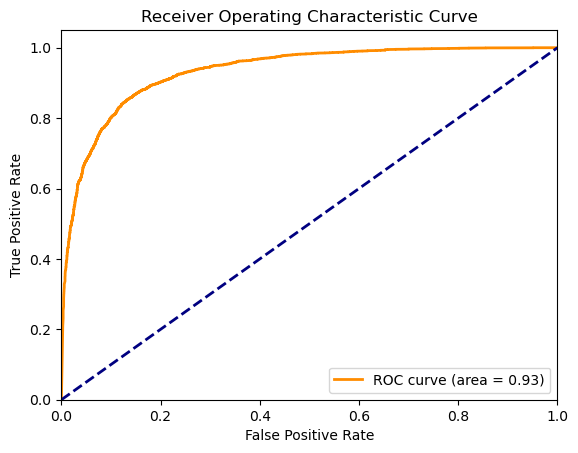

In [44]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()